# Estimates of dissipation rate using finescale parametrizations

Notes on shearstrain parametrization:

Shear-based parametrization:
\begin{align}
    \epsilon = \epsilon_0 \frac{\overline{N}^2}{N_0^2} \frac{<V_z^2>^2}{<V_z^2>_{GM}^2} h_1(R_\omega)j(f/N)
\end{align}

Strain-based parametrization:
\begin{align}
    \epsilon = \epsilon_0 \frac{\overline{N}^2}{N_0^2} \frac{<\xi_z^2>^2}{<\xi_z^2>_{GM}^2} h_2(R_\omega)j(f/N)
\end{align}

Strain:
\begin{align}
    <\xi_z^2> = (N^2 - \overline{N}^2)/\overline{N}^2 \\
    <{}_{\theta}\xi_z^2> = (\theta_z - \overline{\theta}_z)/\overline{\theta_z}
\end{align}

with 
$R_\omega$ the shear-to-strain variance ratio,
\begin{align}
    R_\omega = \frac{<V_z^2>}{\overline{N}<\xi_z^2>}
\end{align}

and $h_1$, $h_2$ and j functions such as,
\begin{align}
    h_1(R_\omega) = \frac{3(R_\omega+1)}{2\sqrt{2} R_\omega\sqrt{R_\omega-1}} \\
    h_2(R_\omega) = \frac{1}{6\sqrt{2}}\frac{R_\omega(R_\omega+1)}{R_\omega\sqrt{R_\omega-1}} \\
    j(f/N) = \frac{arcosh(N/f)}{f_{30}arcosh(N_0/f_{30})}
\end{align}

In our case, only the velocity is available at all moorings, thus we will only use the shear-based parametrization. In the absence of estimates of the strain, the shear-to-strain ratio ust be fixed. The value fixed by Garrett-Munk is 3 and usually used.

The estimates of dissipation rate obtained through the implementation of this method will depend on a few choices:

1/ $R_\omega$

2/ Temperature estimates (mooring or climatology)

3/ Size of the window used to estimate shear spectra


In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime,timedelta
import pandas as pd
import scipy
import mixsea
import niskine
import mplniw.plot as pl
import gvpy as gv
import mplniw.sigp as sp
import mplniw.utils as ut
import gsw

In [2]:
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d

from mixsea import helpers, nsq



def wavenumber_vector(w):
    r"""
    Generate wavenumber vector

    Wavenumber vector runs from
    :math:`\frac{2 \pi}{\textrm{w}}` to
    :math:`\frac{2 \pi}{10}` in increments of
    :math:`\frac{2 \pi}{\textrm{w}}`.

    Parameters
    ----------
    w : float
        window size [m]

    Returns
    -------
    m : array
        Wavenumber vector
    """
    return np.arange(2 * np.pi / w, 2 * np.pi / 10, 2 * np.pi / w)





def strain_polynomial_fits(depth, t, SP, lon, lat, depth_bin, window_size):
    """
    Calculate strain with a smooth :math:`N^2` profile from polynomial fits to windowed data.

    This version outputs polyfit and strain for the whole window as opposed to
    just half the window centered.

    Parameters
    ----------
    depth : array-like
        CTD depth [m]
    t : array-like
        CTD in-situ temperature [ITS-90, degrees C]
    SP : array-like
        CTD practical salinity [psu]
    lon : array-like or float
        Longitude
    lat : array-like or float
        Latitude
    depth_bin : float
        Window centers
    window_size : float
        Window size

    Returns
    -------
    list
        List with results in a dict for each depth segment. The dict has the following entries:

        - ``"segz"``: Segment depth vector (`array-like`).

        - ``"depth_bin"``: Segment center depth (`float`).

        - ``"N2"``: Segment buoyancy frequency squared (`array-like`).

        - ``"N2smooth"``: Segment polynomial fit to buoyancy frequency squared (`array-like`).

        - ``"N2mean"``: Segment mean buoyancy frequency squared (`float`).

        - ``"strain"``: Segment strain (`array-like`).

    """
    # Prepare output list. It will hold a dictionary with data for each window.
    out = []
    dz = np.absolute(np.median(np.diff(depth)))
    # Calculate buoyancy frequency.
    pr = gsw.p_from_z(-1 * depth, lat)
    SA = gsw.SA_from_SP(SP, pr, lon, lat)
    CT = gsw.CT_from_t(SA, t, pr)
    N2, pr_mid = gsw.Nsquared(SA, CT, pr, lat=lat)
    depth_mid = -1 * gsw.z_from_p(pr_mid, lat)
    isN = np.isfinite(N2)
    # Second order polynomial fit for each depth window.
    for iwin, zw in enumerate(depth_bin):
        # Find data points within the depth window. As we are operating on the
        # mid-points here, we extend the search for datapoints by delta z on
        # each side of the window.
        ij = (depth_mid >= (zw - window_size / 2 - dz)) & (
            depth_mid < (zw + window_size / 2 + dz)
        )
        ij = ij * isN
        seg = {"depth_bin": zw, "segz": depth_mid[ij], "N2": N2[ij]}
        p = np.polyfit(depth_mid[ij], N2[ij], deg=2)
        seg["N2smooth"] = np.polyval(p, depth_mid[ij])
        seg["N2mean"] = np.mean(seg["N2smooth"])
        # Calculate strain
        seg["strain"] = (seg["N2"] - seg["N2smooth"]) / seg["N2mean"]
        out.append(seg)
    return out





def strain_adiabatic_leveling(
    depth, t, SP, lon, lat, bin_width, depth_bin, window_size
):
    """
    Calculate strain with a smooth :math:`N^2` profile based on the adiabatic leveling method.

    Parameters
    ----------
    depth : array-like
        CTD depth [m]
    t : array-like
        CTD in-situ temperature [ITS-90, degrees C]
    SP : array-like
        CTD practical salinity [psu]
    lon : array-like or float
        Longitude
    lat : array-like or float
        Latitude
    depth_bin : array-like
        Window centers
    window_size : float
        Window size

    Returns
    -------
    list
        List with results in a dict for each depth segment. The dict has the following entries:

        - ``"segz"``: Segment depth vector (`array-like`).

        - ``"depth_bin"``: Segment center depth (`float`).

        - ``"N2"``: Segment buoyancy frequency squared (`array-like`).

        - ``"N2smooth"``: Segment polynomial fit to buoyancy frequency squared (`array-like`).
        - ``"N2mean"``: Segment mean buoyancy frequency squared (`float`).

        - ``"strain"``: Segment strain (`array-like`).

    """
    dz = np.absolute(np.median(np.diff(depth)))
    # Prepare output list. It will hold a dictionary with data for each window.
    out = []
    # Calculate pressure
    pr = gsw.p_from_z(-1 * depth, lat)
    # Calculate smooth background N^2
    N2ref = nsq.adiabatic_leveling(
        pr,
        SP,
        t,
        lon,
        lat,
        bin_width=bin_width,
        order=2,
        return_diagnostics=False,
        cap="both",
    )
    # Calculate in-situ N^2
    SA = gsw.SA_from_SP(SP, pr, lon, lat)
    CT = gsw.CT_from_t(SA, t, pr)
    N2, Pbar = gsw.Nsquared(SA, CT, pr, lat=lat)
    depth_mid = -1 * gsw.z_from_p(Pbar, lat)
    # Interpolate smooth N^2 to in-situ N^2
    N2ref = interp1d(pr, N2ref)(Pbar)
    # Calculate strain
    strain = (N2 - N2ref) / N2ref
    isN = np.isfinite(N2) & np.isfinite(N2ref)
    # Sort into depth windows
    for iwin, zw in enumerate(depth_bin):
        # Find data points within the depth window. As we are operating on the
        # mid-points here, we extend the search for datapoints by delta z on
        # each side of the window.
        ij = (depth_mid >= (zw - window_size / 2 - dz)) & (
            depth_mid < (zw + window_size / 2 + dz)
        )
        ij = ij * isN
        seg = {"depth_bin": zw, "segz": depth_mid[ij], "N2": N2[ij]}
        seg["N2smooth"] = N2ref[ij]
        seg["N2mean"] = np.mean(seg["N2smooth"])
        seg["strain"] = strain[ij]
        out.append(seg)
    return out





def find_cutoff_wavenumber(P, m, integration_limit, lambda_min=5):
    """
    Find cutoff wavenumber for spectrum integration.

    Parameters
    ----------
    P : array-like
        Spectrum
    m : array-like
        Vertical wavenumber vector
    integration_limit : float
        Variance limit for integration
    lambda_min : float, optional
        Minimum vertical wavelength lambda_z=2pi/m, by default 5

    Returns
    -------
    iim : array-like
        Integration range as indexer to `P`.
    """
    specsum = cumtrapz(P, m)
    specsum = np.insert(specsum, 0, 0)
    iim = np.flatnonzero(
        np.less(specsum, integration_limit, where=np.isfinite(specsum))
    )
    if iim.size == 1:  # need at least two data points for integration
        iim = np.append(iim, 1)
    if iim.size > 1:
        # Do not go to wavenumbers corresponding to lambda_z < lambda_min meter
        if np.max(m[iim] / 2 / np.pi) > 1.0 / lambda_min:
            iim = np.where(m / 2 / np.pi < 1.0 / lambda_min)[0]
        return iim, np.max(m[iim])
    else:
        return iim, np.nan





def aspect_ratio_correction_shst(Rw):
    """
    Compute kinematic internal wave aspect ratio term based shear/strain ratio shear/strain parameterization.

    Parameters
    ----------
    Rw : float or np.ndarray

    Returns
    -------
    float or np.ndarray

    """
    return 3 * (Rw + 1) / (2 * np.sqrt(2) * Rw * np.sqrt(Rw - 1))





def aspect_ratio_correction_st(Rw):
    """
    Compute kinematic internal wave aspect ratio term based shear/strain ratio for strain-only parameterization

    Parameters
    ----------
    Rw : float or np.ndarray

    Returns
    -------
    float or np.ndarray

    """
    return 1 / 6 / np.sqrt(2) * Rw * (Rw + 1) / np.sqrt(Rw - 1)





def latitude_correction(f, N):
    r"""
    Latitudinal correction term

    Parameters
    ----------
    f : float
        Coriolis parameter
    N : float
        Buoyancy frequency

    Returns
    -------
    L : float
        Latitudinal correction

    Notes
    -----
    Calculates the latitudinal dependence term as described in Gregg et al.
    (2003) :cite:`Gregg2003`:

    .. math::

        L(\theta, N) = \frac{f \cosh^{-1}(N/f)}{f_{30^{\circ}} \cosh^{-1}(N_0/f_{30^\circ})}

    with Coriolis parameter at 30° latitude :math:`f_{30^\circ}` and reference
    GM buoyancy frequency :math:`N_0=5.24\times10^{-3}\,\mathrm{s}^{-1}`.
    """
    # Coriolis parameter at 30 degrees latitude
    f30 = gsw.f(30)  # rad s-1
    # GM model reference stratification:
    N0 = 5.24e-3  # rad s-1
    f = np.abs(f)
    return f * np.arccosh(N / f) / (f30 * np.arccosh(N0 / f30))




def eps_shearstrain(eps0, Nm, N0, Ssh, Sshgm, Rw, f):
    """
    Parameterized turbulent kinetic energy dissipation rate

    Parameters
    ----------
    eps0 : float
        GM reference dissipation rate
    Nm : float
        background stratification in window
    N0 : float
        GM reference stratification
    Ssh : float
        band-integrated observed shear variance normalized by mean stratification
    Sshgm : float
        band-integrated GM shear variance normalized by GM reference stratification
    Rw : float
        shear/strain ratio
    f : float
        Coriolis frequency
    """
    return (
        eps0
        * (Nm**2 / N0**2)
        * (Ssh**2 / Sshgm**2)
        * (aspect_ratio_correction_shst(Rw) * latitude_correction(f, Nm))
    )


def eps_strain(eps0, Nm, N0, Sst, Sstgm, Rw, f):
    """
    Parameterized turbulent kinetic energy dissipation rate

    Parameters
    ----------
    eps0 : float
        GM reference dissipation rate
    Nm : float
        background stratification in window
    N0 : float
        GM reference stratification
    Sst : float
        band-integrated observed strain normalized by mean stratification
    Sstgm : float
        band-integrated GM strain variance normalized by GM reference stratification
    Rw : float
        shear/strain ratio
    f : float
        Coriolis frequency
    """
    return (
        eps0
        * (Nm**2 / N0**2)
        * (Sst**2 / Sstgm**2)
        * (aspect_ratio_correction_st(Rw) * latitude_correction(f, Nm))
    )


def diffusivity(eps, N, Gam=0.2):
    r"""
    Calculate vertical diffusivity

    Parameters
    ----------
    eps : array-like
        Turbulent dissipation
    N : array-like
        Buoyancy frequency
    Gam : float, optional
        Mixing efficiency Gamma. Defaults to 0.2 as commonly used.

    Returns
    -------
    kappa : array-like
        Vertical diffusivity

    Notes
    -----
    Calculates vertical diffusivity from turbulent dissipation based on a
    constant mixing efficiency:

    .. math::

        \kappa = \Gamma \frac{\epsilon}{N^2}

    """
    return Gam * eps / N**2





def gm_shear_variance(m, iim, N):
    r"""
    GM model shear variance

    Parameters
    ----------
    m : array-like
        Vertical wavenumber vector [rad/m]
    iim : array-like
        Wavenumber integration range, indexer to m
    N : float
        Local buoyancy frequency [s^-1]

    Returns
    -------
    Sgm : float
        GM shear variance normalized by N^2 [1/m^2].
    Pgm : array-like
        GM shear spectrum for wavenumber range `m`.

    Notes
    -----
    Returns GM shear variance normalized by buoyancy frequency by integrating
    `Pgm` over a wavenumber range of the GM shear spectrum  as presented in
    Kunze et al. (2006) :cite:`Kunze2006` eq. 6:

    .. math::

        \frac{_{GM}\left< V_z^2\right>}{\overline{N}^2} = \frac{3 \pi E_0 b j_\ast}{2} \int_{m_\mathrm{min}}^{m_\mathrm{max}} \frac{m^2 dm}{(m + m_\ast)^2}

    with :math:`j_\ast=3`, :math:`E_0=6.3\times10^{-5}`, :math:`N_0=5.2\times
    10^{-3}` rad/s, :math:`b=1300` m, and

    .. math::

        m_\ast = \frac{\overline{N}}{N_0}\frac{\pi j_\ast}{b}

    See also
    --------
    gm_strain_variance : GM strain variance
    """
    N0 = 5.24e-3  # reference buoyancy frequency = 3 cph
    b = 1300  # thermocline scale depth
    jstar = 3
    E0 = 6.3e-5  # GM76 energy level
    Pgm = (
        (3 * np.pi * E0 * b * jstar / 2)
        * m**2
        / (m + jstar * np.pi / b * N / N0) ** 2
    )
    # integrate
    Sgm = np.trapz(y=Pgm[iim], x=m[iim])
    return Sgm, Pgm






def gm_strain_variance(m, iim, N):
    r"""
    GM model strain variance.

    Parameters
    ----------
    m : array-like
        Vertical wavenumber vector [rad/m].
    iim : array-like
        Wavenumber integration range, indexer to `m`.
    N : float
        Local buoyancy frequency [s^-1].

    Returns
    -------
    Sgm : float
        GM strain variance normalized by N^2 [1/m^2].
    Pgm : array-like
        GM strain spectrum for wavenumber range `m`.

    Notes
    -----
    Returns GM strain variance by integrating `Pgm` over a wavenumber range of
    the GM shear spectrum  as presented in Kunze et al. (2006)
    :cite:`Kunze2006` eq. 10:

    .. math::

        \frac{_{GM}\left< V_z^2\right>}{\overline{N}^2} = \frac{\pi E_0 b j_\ast}{2} \int_{m_\mathrm{min}}^{m_\mathrm{max}} \frac{m^2 dm}{(m + m_\ast)^2}

    with :math:`j_\ast=3`, :math:`E_0=6.3\times10^{-5}`, :math:`N_0=5.2\times
    10^{-3}` rad/s, :math:`b=1300` m, and

    .. math::

        m_\ast = \frac{\overline{N}}{N_0}\frac{\pi j_\ast}{b}

    Note that this corresponds to the buoyancy-normalized GM shear variance
    divided by 3.

    See also
    --------
    gm_shear_variance : GM shear variance

    """
    N0 = 5.24e-3  # reference buoyancy frequency = 3 cph
    b = 1300  # thermocline scale depth
    jstar = 3
    E0 = 6.3e-5  # GM energy level
    Pgm = (np.pi * E0 * b * jstar / 2) * m**2 / (m + jstar * np.pi / b * N / N0) ** 2
    # integrate
    Sgm = np.trapz(y=Pgm[iim], x=m[iim])
    return Sgm, Pgm






def nan_shearstrain(
    depth, t, SP, lon, lat, ladcp_u=None, ladcp_v=None, ladcp_depth=None, **kwargs
):
    """Compute krho and epsilon via shear/strain parameterization attempting to deal NaN values in the input data.

    See `shearstrain` for details.
    """
    depth = np.asarray(depth)
    t = np.asarray(t)
    SP = np.asarray(SP)

    # Look for NaNs in CTD.
    notnan = np.isfinite(SP) & np.isfinite(t) & np.isfinite(depth)
    isnan = ~notnan

    # Look for NaNs in shear/velocity. These do not determine the output shape,
    # therefore we can just get rid of the NaNs inside `kwargs`.
    if ladcp_u is not None:
        notnansh = (
            np.isfinite(ladcp_u) & np.isfinite(ladcp_v) & np.isfinite(ladcp_depth)
        )
        isnansh = ~notnansh
        if isnansh.sum() > 0:
            ladcp_u = ladcp_u[notnansh]
            ladcp_v = ladcp_v[notnansh]
            ladcp_depth = ladcp_depth[notnansh]

    if isnan.sum() == 0:  # If there are no NaNs in CTD data then return.
        return shearstrain(
            depth, t, SP, lon, lat, ladcp_u, ladcp_v, ladcp_depth, **kwargs
        )

    # Don't want to pass return_diagnostics twice.
    if "return_diagnostics" in kwargs:
        return_diagnostics = kwargs.pop("return_diagnostics")
    else:
        return_diagnostics = False

    eps_shst, krho_shst, diag = shearstrain(
        depth[notnan],
        t[notnan],
        SP[notnan],
        lon,
        lat,
        ladcp_u,
        ladcp_v,
        ladcp_depth,
        return_diagnostics=True,
        **kwargs,
    )

    if return_diagnostics:
        return eps_shst, krho_shst, diag
    else:
        return eps_shst, krho_shst





def shearstrain(
    depth,
    t,
    SP,
    lon,
    lat,
    ladcp_u=None,
    ladcp_v=None,
    ladcp_depth=None,
    method='strain',
    Rw=3,
    m=None,
    depth_bin=None,
    window_size=None,
    m_include_sh=np.arange(4),
    m_include_st=np.arange(4),
    ladcp_is_shear=False,
    smooth="AL",
    sh_integration_limit=0.66,
    st_integration_limit=0.22,
    window="hamming",
    return_diagnostics=False,
):
    """
    Compute krho and epsilon from CTD/LADCP data via the shear/strain parameterization.

    Parameters
    ----------
    depth : array-like
        CTD depth [m]
    t : array-like
        CTD in-situ temperature [ITS-90, degrees C]
    SP : array-like
        CTD practical salinity [psu]
    lon : array-like or float
        Longitude
    lat : array-like or float
        Latitude
    ladcp_u : array-like, optional
        LADCP velocity east-west component [m/s]. If not provided, only the
        strain solution with a fixed shear/strain ratio of 3 will be computed.
    ladcp_v : array-like, optional
        LADCP velocity north-south component [m/s]
    ladcp_depth : array-like, optional
        LADCP depth vector [m]
    m : array-like, optional
        Wavenumber vector to interpolate spectra onto
    depth_bin : array-like, optional
        Centers of windows over which spectra are computed. Defaults to
        np.arange(75, max(depth), 150). Note that windows are half-overlapping so
        the 150 spacing above means each window is 300 m tall.
    window_size : float
        Size of depth window [m].
    m_include_sh : array-like, optional
        Wavenumber integration range for shear spectra. Array must consist of
        indices or boolans to index m. Defaults to first 4 wavenumbers.
    m_include_st : array-like, optional
        Wavenumber integration range for strain spectra. Array must consist of
        indices or boolans to index m. Defaults to first 4 wavenumbers.
    ladcp_is_shear : bool, optional
        Indicate whether LADCP data is velocity or shear.
        Defaults to False (velocity).
    smooth : {'AL', 'PF'}, optional
        Select type of N^2 smoothing and subsequent strain calculation. 'AL'
        selects the adiabatic leveling method as applied in
        `strain_adiabatic_leveling`. 'PF' selects second order polynomial fits
        to the buoyancy frequency in each window as applied in
        `strain_polynomial_fits`. Defaults to the adiabatic leveling method.
    sh_integration_limit : float, optional
        Shear variance level for determining integration cutoff wavenumber.
        Defaults to 0.66, compare Gargett (1990) :cite:`Gargett1990` and Gregg
        et al. (2003) :cite:`Gregg2003`.
    st_integration_limit : float, optional
        Strain variance level for determining integration cutoff wavenumber.
        Defaults to 0.22, compare Gargett (1990) :cite:`Gargett1990` and Gregg
        et al. (2003) :cite:`Gregg2003`.
    window : str or tuple, optional
        Window type. Defaults to 'hamming' (which corresponds to a sin square
        taper as used in various studies. See `scipy.signal.get_window` for
        details.
    return_diagnostics : bool, optional
        Default is False. If True, this function will return a dictionary
        containing variables such as shear spectra, shear/strain ratios,

    Returns
    -------
    eps_shst : array-like
        Epsilon calculated from both shear and strain spectra
    krho_shst : array-like
        krho calculated from both shear and strain spectra
    diag : dict, optional
        Dictionary of diagnostic variables, set return with the
        `return_diagnostics' argument. `diag` holds the following variables:

        ``"P_shear"``
            Matrix of shear spectra for each depth window (`array-like`).
        ``"P_strain"``
            Matrix of strain spectra for each depth window
        ``"Mmax_sh"``
            Cutoff wavenumber kc (`array-like`).
        ``"Mmax_st"``
            Cutoff wavenubmer used for strain only calculation (`array-like`).
        ``"Rwtot"``
            Shear/strain ratio used, computed from spectra unless specificed in
            input (`array-like`).
        ``"krho_st"``
            krho calculated from strain only (`array-like`).
        ``"eps_st"``
            Epsilon calculated from strain only (`array-like`).
        ``"m"``
            Wavenumber vector (`array-like`).
        ``"depth_bin"``
            Center points of depth windows (`array-like`).
        ``"strain"``
            Results from strain calculation (`dict`).
        ``"Int_sh"``
            Results from shear variance integration (`array-like`).
        ``"Int_st"``
            Results from strain variance integration (`array-like`).

    Notes
    -----
    Adapted from Jen MacKinnon and Amy Waterhouse.
    """
    # Average lon, lat into one value if they are vectors.
    lon = np.nanmean(lon)
    lat = np.nanmean(lat)

    depth = np.asarray(depth)
    t = np.asarray(t)
    SP = np.asarray(SP)

    # Make sure there are no NaNs in the input data
    notnan = np.isfinite(SP) & np.isfinite(t) & np.isfinite(depth)
    isnan = ~notnan
    if not isnan.sum() == 0:
        raise ValueError(
            "No NaNs allowed in CTD data. Consider using `nan_shearstrain` instead."
        )

    # Can we work with velocity data?
    calcsh = False if ladcp_u is None else True
    calcst = True if np.any(np.isin(method,['shearstrain','strain'])) else False
    
    # No NaNs in velocity/shear data
    if calcsh:
        ladcp_u = np.asarray(ladcp_u)
        ladcp_v = np.asarray(ladcp_v)
        ladcp_depth = np.asarray(ladcp_depth)
        notnansh = (
            np.isfinite(ladcp_u) & np.isfinite(ladcp_v) & np.isfinite(ladcp_depth)
        )
        isnansh = ~notnansh
        if not isnansh.sum() == 0:
            raise ValueError(
                "No NaNs allowed in LADCP data. Consider using `nan_shearstrain` instead."
            )

    # Coriolis parameter for this latitude
    f = np.absolute(gsw.f(lat))

    if calcsh:
        depth_sh = ladcp_depth

        # Calculate shear if necessary
        if ladcp_is_shear is False:
            uz = helpers.calc_shear(ladcp_u, depth_sh)
            vz = helpers.calc_shear(ladcp_v, depth_sh)
            #print(uz)
        else:
            uz = ladcp_u
            vz = ladcp_v

    # Create an evenly spaced wavenumber vector if none was provided
    if m is None:
        m = wavenumber_vector(w=300)

    # Generate depth bin vector if none provided
    if depth_bin is None:
        depth_bin = np.arange(75, np.max(depth), 160)
    else:
        # cut out any bins that won't hold any data
        depth_bin = depth_bin[depth_bin < np.max(depth)]
    nz = np.squeeze(depth_bin.shape)
    # delz = np.mean(np.diff(depth_bin))

    # Calculate a smoothed N^2 profile and strain, either using 2nd order
    # polynomial fits to N^2 for each window (PF) or the adiabatic leveling
    # method (AL). Returns a list with data dict for each depth window.
    if smooth == "PF":
        straincalc = strain_polynomial_fits(
            depth, t, SP, lon, lat, depth_bin, window_size
        )
    elif smooth == "AL":
        straincalc = strain_adiabatic_leveling(
            depth,
            t,
            SP,
            lon,
            lat,
            bin_width=300,
            depth_bin=depth_bin,
            window_size=window_size,
        )

    # Convert wavenumber integration range to np.array in case it is something
    # else:
    m_include_sh = np.asarray(m_include_sh)
    m_include_st = np.asarray(m_include_st)

    N0 = 5.24e-3  # (3 cph)
    Gam0 = 0.2  # mixing coefficient

    # GM dissipation level
    eps0 = 7.8e-10  # Waterman et al. 2014
    # eps0 = 7.9e-10 # Polzin et al. 1995
    # eps0 = 6.73e-10 # Gregg et al. 2003

    P_shear = np.full((nz, m.size), np.nan)
    P_strain = P_shear.copy()
    Mmax_sh = np.full(nz, np.nan)
    Mmax_st = Mmax_sh.copy()
    Rwtot = np.full(nz, np.nan)
    Rwcor = np.full(nz, np.nan)
    Nmseg = np.full(nz, np.nan)
    krho = np.full(nz, np.nan)
    krho = np.full(nz, np.nan)
    eps = np.full(nz, np.nan)
    eps = np.full(nz, np.nan)
    Int_st = np.full(nz, np.nan)
    Int_sh = np.full(nz, np.nan)
    Int_st_gm = np.full(nz, np.nan)
    Int_sh_gm = np.full(nz, np.nan)
    #print(straincalc)
    for iwin, (zi, sti) in enumerate(zip(depth_bin, straincalc)):
        assert zi == sti["depth_bin"]
        zw = depth_bin[iwin]

        # Shear spectra
        if calcsh:
            iz = (depth_sh >= (zw - window_size / 2)) & (
                depth_sh <= (zw + window_size / 2)
            )
            # Buoyancy-normalize shear
            shear_un = uz[iz] / np.real(np.sqrt(sti["N2mean"]))
            shear_vn = vz[iz] / np.real(np.sqrt(sti["N2mean"]))
            shearn = shear_un + 1j * shear_vn
            ig = ~np.isnan(shearn)
            
            if np.flatnonzero(ig).size > 10:
                dz = np.mean(np.diff(depth_sh[iz]))
                _, _, Ptot, m0 = helpers.psd(
                    shearn[ig], dz, ffttype="t", detrend=True, window=window
                )
                # Compensation for first differencing
                H = np.sinc(m0 * dz / 2 / np.pi) ** 2
                Ptot = Ptot / H
                Ptot_sh = interp1d(m0, Ptot, bounds_error=False)(m)
                P_shear[iwin, :] = Ptot_sh
            else:
                P_shear[iwin, :] = np.nan
                Ptot_sh = np.zeros_like(m) * np.nan

        if calcst:
            # Strain spectra
            # iz = (depth_st >= (zw - delz)) & (depth_st <= (zw + delz))
            segstrain = sti["strain"]
            segstraindep = sti["segz"]
            ig = ~np.isnan(segstrain)
            
            if np.flatnonzero(ig).size > 10:
                dz = np.mean(np.diff(segstraindep))
                _, _, Ptot, m0 = helpers.psd(
                    segstrain[ig], -dz, ffttype="t", detrend=True, window=window
                )
                # Compensation for first differencing
                H = np.sinc(m0 * dz / 2 / np.pi) ** 2
                Ptot = Ptot / H
                Ptot_st = interp1d(m0, Ptot, bounds_error=False)(m)
                P_strain[iwin, :] = Ptot_st
            
            else:
                P_strain[iwin, :] = np.nan
                Ptot_st = np.zeros_like(m) * np.nan
        
        # Mean stratification per segment
        Nm = np.sqrt(sti["N2mean"])
        Nmseg[iwin] = Nm
        
        # Shear cutoff wavenumber
        if calcsh:
            iimsh, Mmax_sh[iwin] = find_cutoff_wavenumber(
                Ptot_sh[m_include_sh], m[m_include_sh], sh_integration_limit
            )
            iimsh = m_include_sh[iimsh]
        
        # Strain cutoff wavenumber
        if calcst:    
            iimst, Mmax_st[iwin] = find_cutoff_wavenumber(
                Ptot_st[m_include_st], m[m_include_st], st_integration_limit
            )
            iimst = m_include_st[iimst]

        if calcsh:
            # Integrate shear spectrum to obtain shear variance
            Ssh = np.trapz(Ptot_sh[iimsh], m[iimsh])
            Int_sh[iwin] = Ssh
            # GM shear variance
            Sshgm, Pshgm = gm_shear_variance(m, iimsh, Nm)
            Int_sh_gm[iwin] = Sshgm
            
        if calcst:
            # Integrate strain spectrum to obtain strain variance
            Sst = np.trapz(Ptot_st[iimst], m[iimst])
            Int_st[iwin] = Sst
            # GM strain variance
            Sstgm, Pstgm = gm_strain_variance(m, iimst, Nm)
            Int_st_gm[iwin] = Sstgm

        if method=='shearstrain':
            # Shear/strain ratio normalized by GM. Factor 3 corrects for the ratio
            # of GM shear to strain = 3 N^2.
            Rw =  Ssh / Sst / Nm
            #Rw = 3 * (Ssh / Sshgm) / (Sst / Sstgm)
            Rwtot[iwin] = Rw
            # Avoid negative square roots in hRw below
            _Rw = 1.01 if Rw < 1.01 else Rw
            Rwcor[iwin] = _Rw

            # Shear/strain parameterization
            eps[iwin] = eps_shearstrain(eps0, Nm, N0, Ssh, Sshgm, Rw, f)
            krho[iwin] = diffusivity(eps[iwin], Nm, Gam=Gam0)
            
        if method=='shear':
            # Shear only parameterization
            Rw = Rw
            eps[iwin] = eps_shearstrain(eps0, Nm, N0, Ssh, Sshgm, Rw, f)
            krho[iwin] = diffusivity(eps[iwin], Nm, Gam=Gam0)
            
        if method=='strain':
            # Strain only parameterization
            # Use assumed shear/strain ratio of 3
            Rw = Rw
            eps[iwin] = eps_strain(eps0, Nm, N0, Sst, Sstgm, Rw, f)
            krho[iwin] = diffusivity(eps[iwin], Nm, Gam=Gam0)

    if return_diagnostics:
        diag = dict(
            eps=eps,
            krho=krho,
            P_shear=P_shear,
            P_strain=P_strain,
            #Mmax_sh=Mmax_sh,
            #Mmax_st=Mmax_st,
            Rwtot=Rwtot,
            Rwcor=Rwcor,
            #Nmseg=Nmseg,
            #m=m,
            depth_bin=depth_bin,
            #strain=straincalc,
            #Int_sh=Int_sh,
            #Int_st=Int_st,
            #Int_sh_gm=Int_sh_gm,
            #Int_st_gm=Int_st_gm,
        )
        return eps, krho, diag
    else:
        return eps, krho

In [3]:
#Load configuration for one mooring
mooring=1
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=mooring)
root_dir = '/Users/zcasparcohen/codes/NIW/'
figdir = '/Users/zcasparcohen/Documents/NISKINE/Figures/'

In [4]:
# Load Data at the mooring

# Wind
wind_work = xr.open_dataset(root_dir+'data/ni_wind_work_niskine_m1.nc').rename({'__xarray_dataarray_variable__':'wind_work'})
wind_stress = xr.open_dataset(root_dir+'data/wind_work/wind_stress_niskine_m1.nc')

#Velocity time series
ds = xr.open_dataset(root_dir+'data/NI02_M%s.nc'%mooring)
gridded=xr.open_dataset(root_dir+'data/M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
wkb = niskine.clim.get_wkb_factors(gridded)
ds['bpuz'] = wkb*ds['u_filtered'].differentiate('z')
ds['bpvz'] = wkb*ds['v_filtered'].differentiate('z')

ds['uz'] = ds['u'].differentiate('z')
ds['vz'] = ds['v'].differentiate('z')

#Vorticity
vort = xr.open_dataset(root_dir+'data/vorticity_moorings.nc')
vort_alt = xr.open_dataset(root_dir+'data/vorticity_alt.nc')

#Buoyancy frequency
N2 = xr.open_dataset(root_dir+'data/N_daily.nc').rename({'__xarray_dataarray_variable__':'N2'})

In [5]:
ds['KE_mld'] = ds.ni_ke_wkb.where(ds.z<ds.mld+100).mean('z')
ds['wind_work_diff'] = np.abs(wind_work['wind_work']).cumsum().differentiate('time')
ds['bpUVz'] = ds.bpuz + 1j* ds.bpvz
ds['UVz'] = ds.uz + 1j* ds.vz

In [6]:
# Temperature from the mooring
Temp = xr.open_dataset(root_dir+'data/t_10m.nc').rename({'__xarray_dataarray_variable__':'temp'})

In [7]:
# Climatology from WOCE Atlas
woce = gv.ocean.woce_argo_profile(lon=lon, lat=lat)
SP = woce.s
SP_interp = niskine.clim.interpolate_seasonal_data(Temp.time, SP.transpose()).rename({'z':'depth'})
SP_interp = SP_interp.interp(depth=Temp.depth).where(np.isnan(Temp.temp)==False)

T = woce.t
T_interp = niskine.clim.interpolate_seasonal_data(Temp.time, T.transpose()).rename({'z':'depth'})
T_interp = T_interp.interp(depth=Temp.depth).where(np.isnan(Temp.temp)==False)

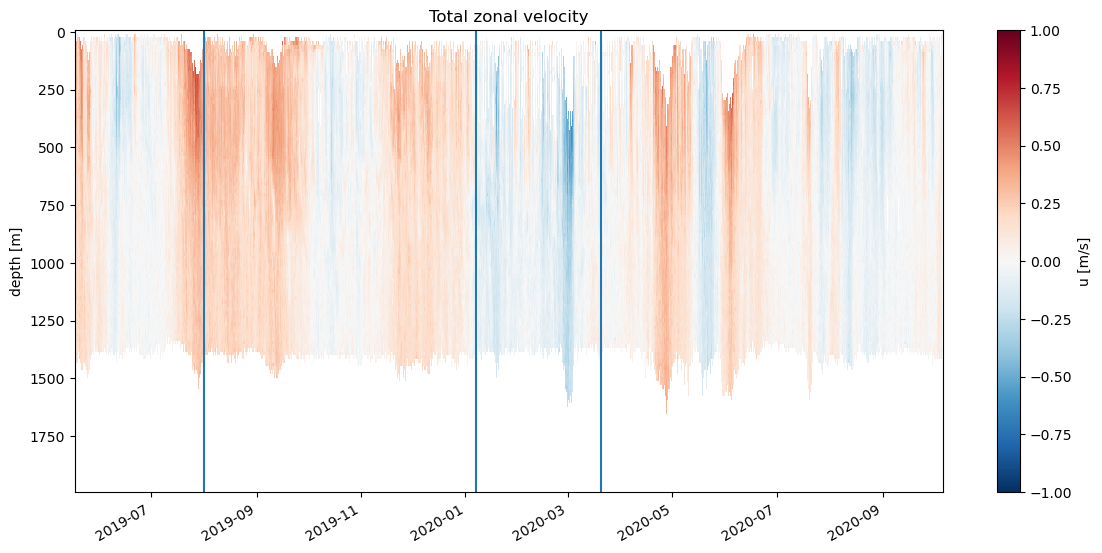

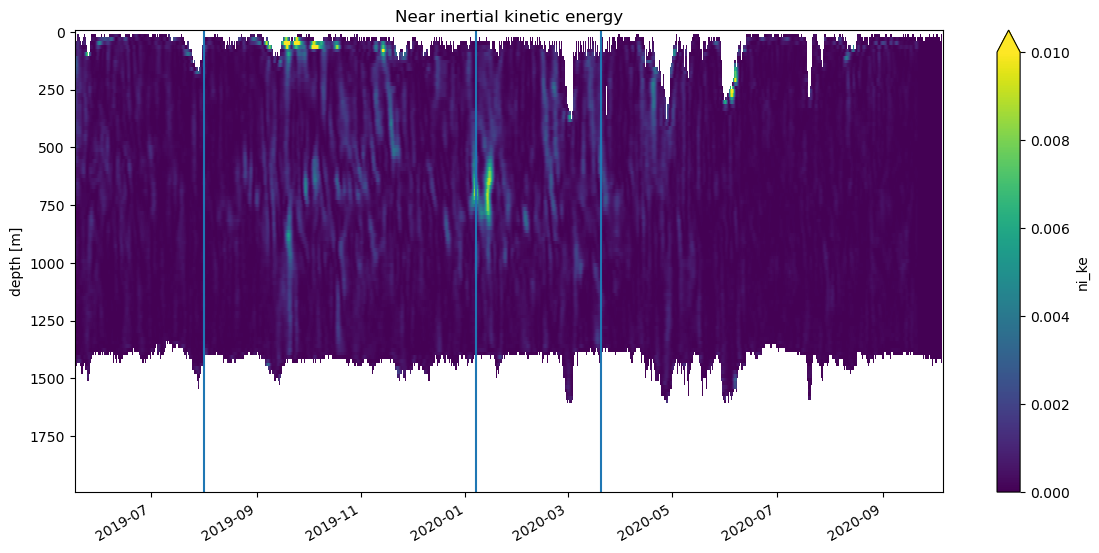

In [79]:
t1 = '2020-01-07'
t0 = '2019-08-01'
t2 = '2020-03-20'
fig,ax = plt.subplots(figsize=(14,6))
ds.u.plot(ax=ax,yincrease=False,vmax=1)
ax.set_title('Total zonal velocity')
ax.axvline(np.datetime64(t0))
ax.axvline(np.datetime64(t1))
ax.axvline(np.datetime64(t2))

fig,ax = plt.subplots(figsize=(14,6))
ds.ni_ke.plot(ax=ax,yincrease=False,vmax=1e-2)
ax.set_title('Near inertial kinetic energy')
ax.axvline(np.datetime64(t0))
ax.axvline(np.datetime64(t1))
ax.axvline(np.datetime64(t2))

Text(0.5, 0, 'Meridional velocity [$ms^{-1}$]')

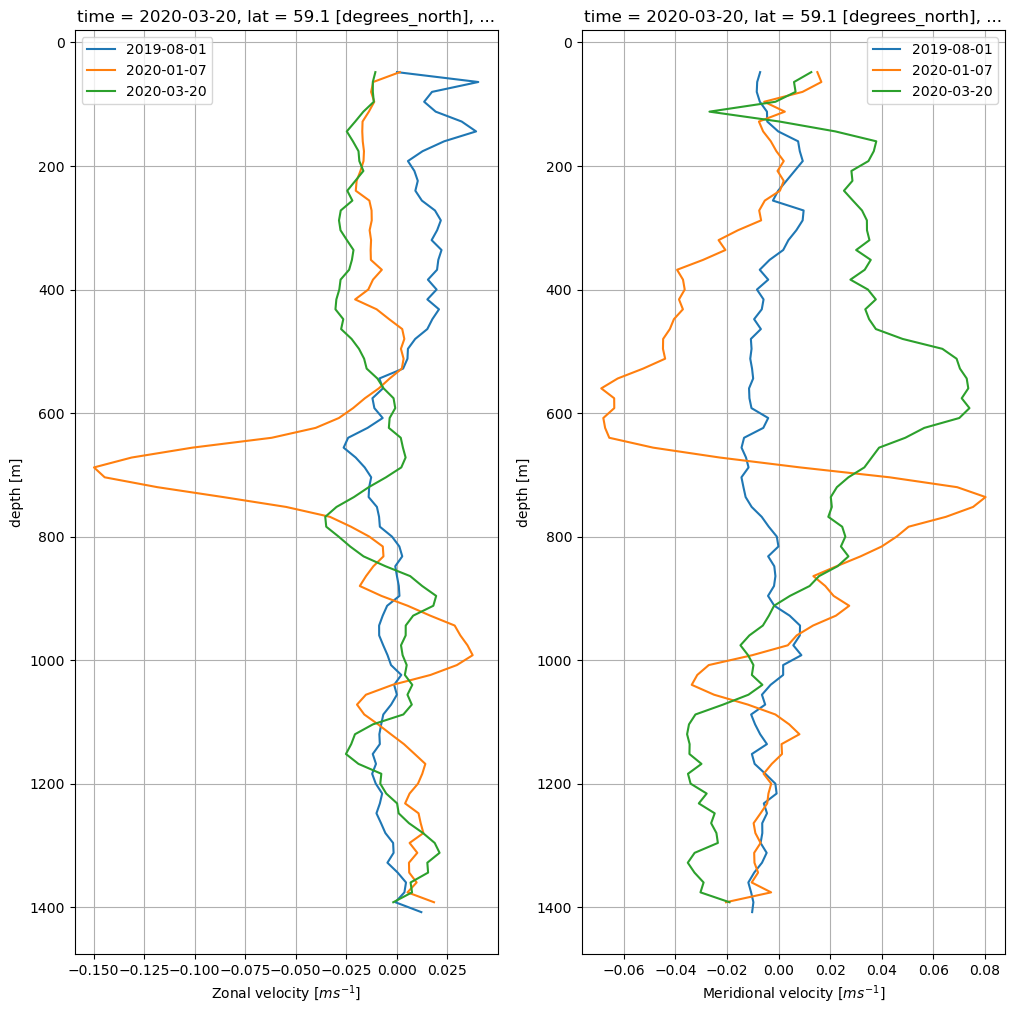

In [11]:
fig,axs = plt.subplots(1,2,figsize=(12,12))
ax = axs[0]
ds.u_filtered.sel(time=t0,method='nearest').plot(ax=ax,y='z',yincrease=False,label=t0)
ds.u_filtered.sel(time=t1,method='nearest').plot(ax=ax,y='z',yincrease=False,label=t1)
ds.u_filtered.sel(time=t2,method='nearest').plot(ax=ax,y='z',yincrease=False,label=t2)
ax.legend();ax.grid();ax.set_xlabel(r'Zonal velocity [$ms^{-1}$]')

ax = axs[1]
ds.v_filtered.sel(time=t0,method='nearest').plot(ax=ax,y='z',yincrease=False,label=t0)
ds.v_filtered.sel(time=t1,method='nearest').plot(ax=ax,y='z',yincrease=False,label=t1)
ds.v_filtered.sel(time=t2,method='nearest').plot(ax=ax,y='z',yincrease=False,label=t2)
ax.legend();ax.grid();ax.set_xlabel(r'Meridional velocity [$ms^{-1}$]')

### Test cases

In [12]:
def select_t(t):
    _t = Temp.temp.sel(time=t,method='nearest')  # using temperature from the mooring
    _t_clim = T_interp.sel(time=t,method='nearest')  #using temperature from climatology
    _s = SP_interp.sel(time=t,method='nearest')
    depth = Temp.sel(time=t,method='nearest').depth
    u = ds.u.sel(time=t,method='nearest')
    v = ds.v.sel(time=t,method='nearest')
    u_depth = ds.sel(time=t,method='nearest').z
    return _t,_t_clim,_s,u,v,depth,u_depth

#### Impact fo the shear-to-strain ratio

In [ ]:
t=t2
_t,_t_clim,_s,u,v,depth,u_depth = select_t(t)
eps,krho,diag_sh_rw10 = nan_shearstrain(depth,_t,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 16) ,window_size=320,return_diagnostics=True,Rw=10)
eps,krho,diag_sh_rw3 = nan_shearstrain(depth,_t,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 16) ,window_size=320,return_diagnostics=True,Rw=3)

eps,krho,diag_sh_rw15 = nan_shearstrain(depth,_t,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 16) ,window_size=320,return_diagnostics=True,Rw=1.5)

Text(0.5, 0, 'Diffusivity')

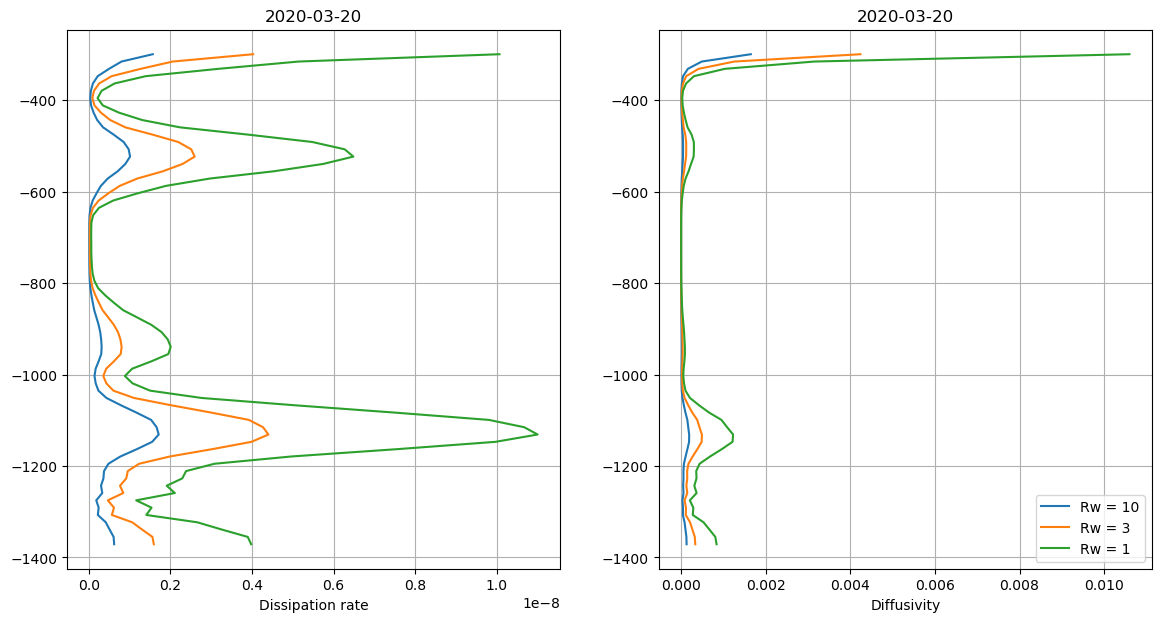

In [39]:
fig,axs = plt.subplots(1,2,figsize=(14,7))
ax=axs[0]
ax.plot(diag_sh_rw10['eps'],-diag_sh_rw3['depth_bin'],label='Rw = 10')
ax.plot(diag_sh_rw3['eps'],-diag_sh_rw3['depth_bin'],label='Rw = 3')
ax.plot(diag_sh_rw15['eps'],-diag_sh_rw3['depth_bin'],label='Rw = 1')
ax.plot();ax.set_title(t);ax.grid();ax.set_xlabel('Dissipation rate')

ax=axs[1]
ax.plot(diag_sh_rw10['krho'],-diag_sh_rw3['depth_bin'],label='Rw = 10')
ax.plot(diag_sh_rw3['krho'],-diag_sh_rw3['depth_bin'],label='Rw = 3')
ax.plot(diag_sh_rw15['krho'],-diag_sh_rw3['depth_bin'],label='Rw = 1')
ax.legend();ax.set_title(t);ax.grid();ax.set_xlabel('Diffusivity')


The shear-to-strain ratio doesn't impact the depth of high or low dissipation rate and diffusivity but will impact strongly its magnitude.

#### Impact of method and local vs climatological temperature

In [ ]:
_t,_t_clim,_s,u,v,depth,u_depth = select_t(t2)
eps,krho,diag_shst = nan_shearstrain(depth,_t,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shearstrain',
                                depth_bin =np.arange(75, np.max(depth), 16) ,window_size=320,return_diagnostics=True)
eps,krho,diag_sh = nan_shearstrain(depth,_t,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 16) ,window_size=320,return_diagnostics=True)
eps,krho,diag_st = nan_shearstrain(depth,_t,_s,lon,lat,
                                method='strain',
                                depth_bin =np.arange(75, np.max(depth), 16) ,window_size=320,return_diagnostics=True)
eps,krho,diag_sh_clim = nan_shearstrain(depth,_t_clim,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 16) ,window_size=320,return_diagnostics=True)


Text(0.5, 0, 'Diffusivity')

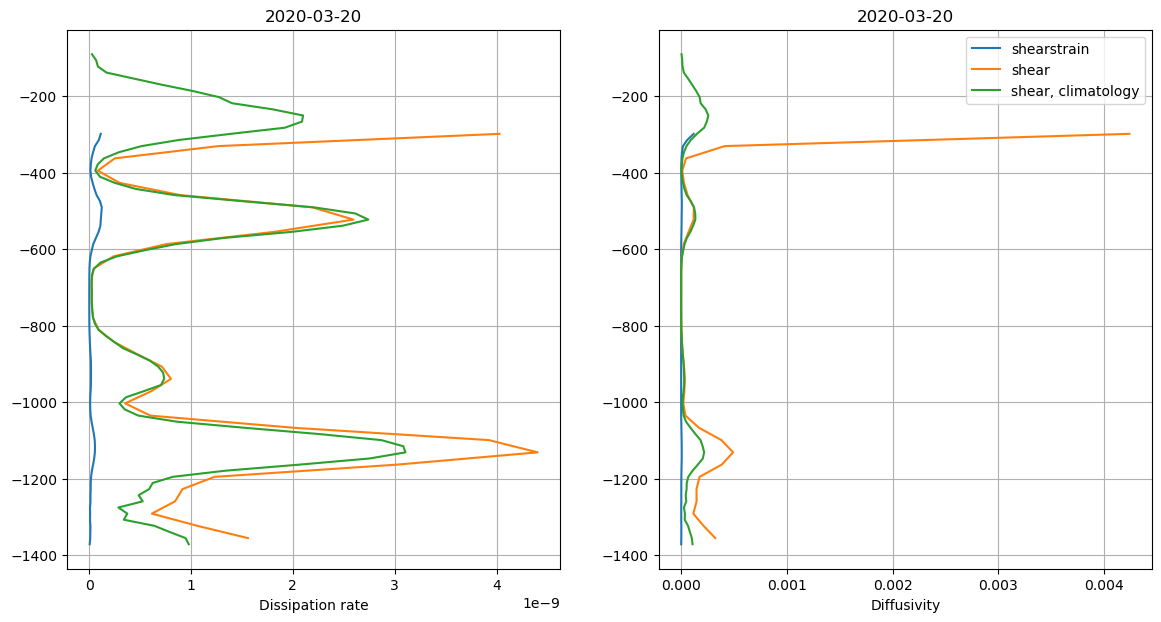

In [38]:
fig,axs = plt.subplots(1,2,figsize=(14,7))
ax=axs[0]
ax.plot(diag_shst['eps'],-diag_shst['depth_bin'],label='shearstrain')
ax.plot(diag_sh['eps'],-diag_sh['depth_bin'],label='shear')
ax.plot(diag_sh_clim['eps'],-diag_sh_clim['depth_bin'],label='shear, climatology')
ax.plot();ax.set_title(t);ax.grid();ax.set_xlabel('Dissipation rate')

ax=axs[1]
ax.plot(diag_shst['krho'],-diag_shst['depth_bin'],label='shearstrain')
ax.plot(diag_sh['krho'],-diag_sh['depth_bin'],label='shear')
ax.plot(diag_sh_clim['krho'],-diag_sh_clim['depth_bin'],label='shear, climatology')
ax.legend();ax.set_title(t);ax.grid();ax.set_xlabel('Diffusivity')


Shearstrain method underestimates the dissipation rate and diffusivity, probably due to a bad estimate of the shear-to-strain variance ratio.

Estimates derived from climatology temperature are lower than the ones from mooring temperature

In the case where NIWs are present, the use of climatology widens the depth range of the estimates and better estimates at the border of the depth range.

Overall for NISKINe moorings, using shear-based parametrization and climatology temperature seems to be more robust.


#### Impact of the window size used to compute shear variance

In [ ]:
_t,_t_clim,_s,u,v,depth,u_depth = select_t(t2)

eps,krho,diag_sh = nan_shearstrain(depth,_t,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 32) ,window_size=320,return_diagnostics=True)
eps,krho,diag_sh_500 = nan_shearstrain(depth,_t,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 32) ,window_size=500,return_diagnostics=True)

eps,krho,diag_sh_800 = nan_shearstrain(depth,_t,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 32) ,window_size=800,return_diagnostics=True)

Text(0.5, 0, 'Diffusivity')

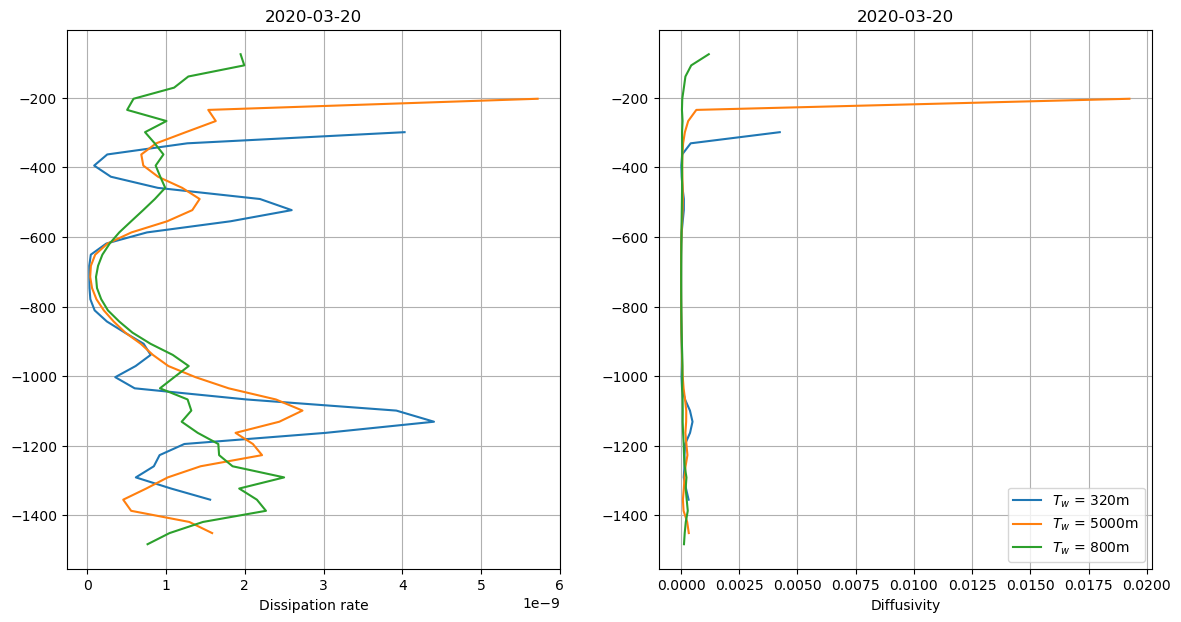

In [37]:
fig,axs = plt.subplots(1,2,figsize=(14,7))
ax=axs[0]
ax.plot(diag_sh['eps'],-diag_sh['depth_bin'],label=r'$T_w$ = 320m')
ax.plot(diag_sh_500['eps'],-diag_sh_500['depth_bin'],label='$T_w$ = 500m')
ax.plot(diag_sh_800['eps'],-diag_sh_800['depth_bin'],label='$T_w$ = 800m')
ax.plot();ax.set_title(t);ax.grid();ax.set_xlabel('Dissipation rate')

ax=axs[1]
ax.plot(diag_sh['krho'],-diag_sh['depth_bin'],label='$T_w$ = 320m')
ax.plot(diag_sh_500['krho'],-diag_sh_500['depth_bin'],label='$T_w$ = 5000m')
ax.plot(diag_sh_800['krho'],-diag_sh_800['depth_bin'],label='$T_w$ = 800m')
ax.legend();ax.set_title(t);ax.grid();ax.set_xlabel('Diffusivity')


A creuser... Lien avec les echelles verticales des dynamiques à observer

### Relation between dissipation rate and NIWs

In [ ]:
_t,_t_clim,_s,u,v,depth,u_depth = select_t(t0)
eps,krho,diag_sh_t0 = nan_shearstrain(depth,_t_clim,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 16) ,window_size=320,return_diagnostics=True)
_t,_t_clim,_s,u,v,depth,u_depth = select_t(t1)
eps,krho,diag_sh_t1 = nan_shearstrain(depth,_t_clim,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 16) ,window_size=320,return_diagnostics=True)

_t,_t_clim,_s,u,v,depth,u_depth = select_t(t2)
eps,krho,diag_sh_t2 = nan_shearstrain(depth,_t_clim,_s,lon,lat,
                                ladcp_u = u,ladcp_v = v,ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 16) ,window_size=320,return_diagnostics=True)

diag_sh = {t0:diag_sh_t0,t1:diag_sh_t1,t2:diag_sh_t2}

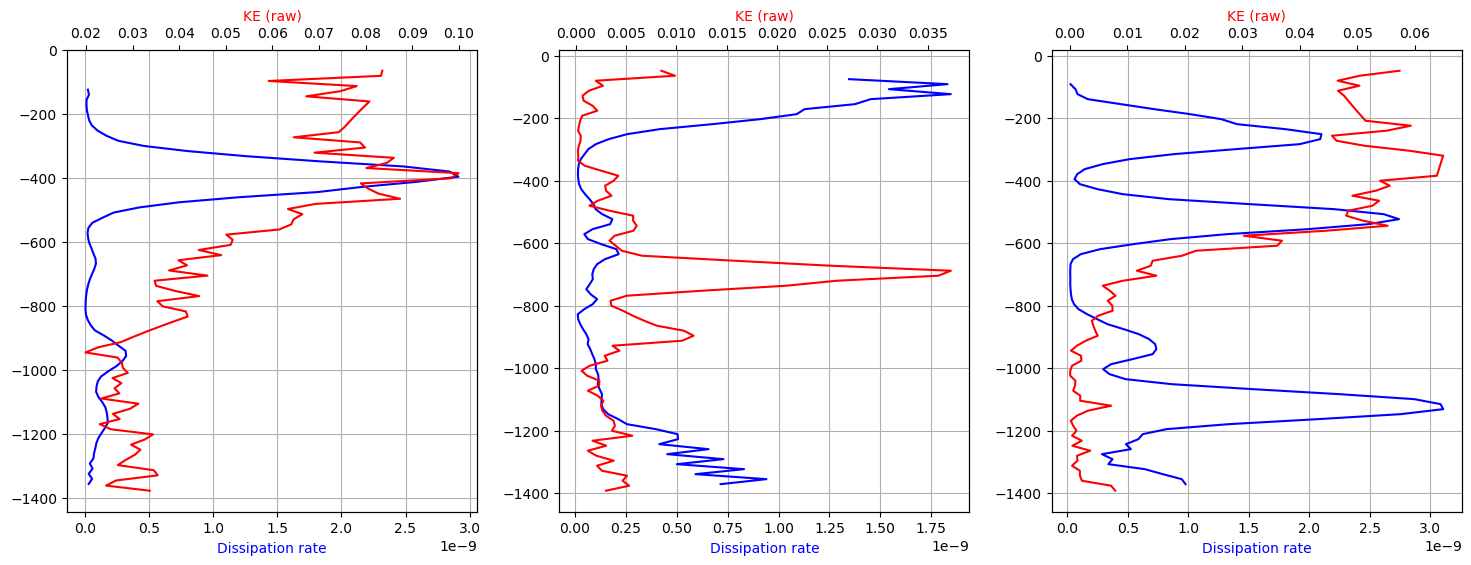

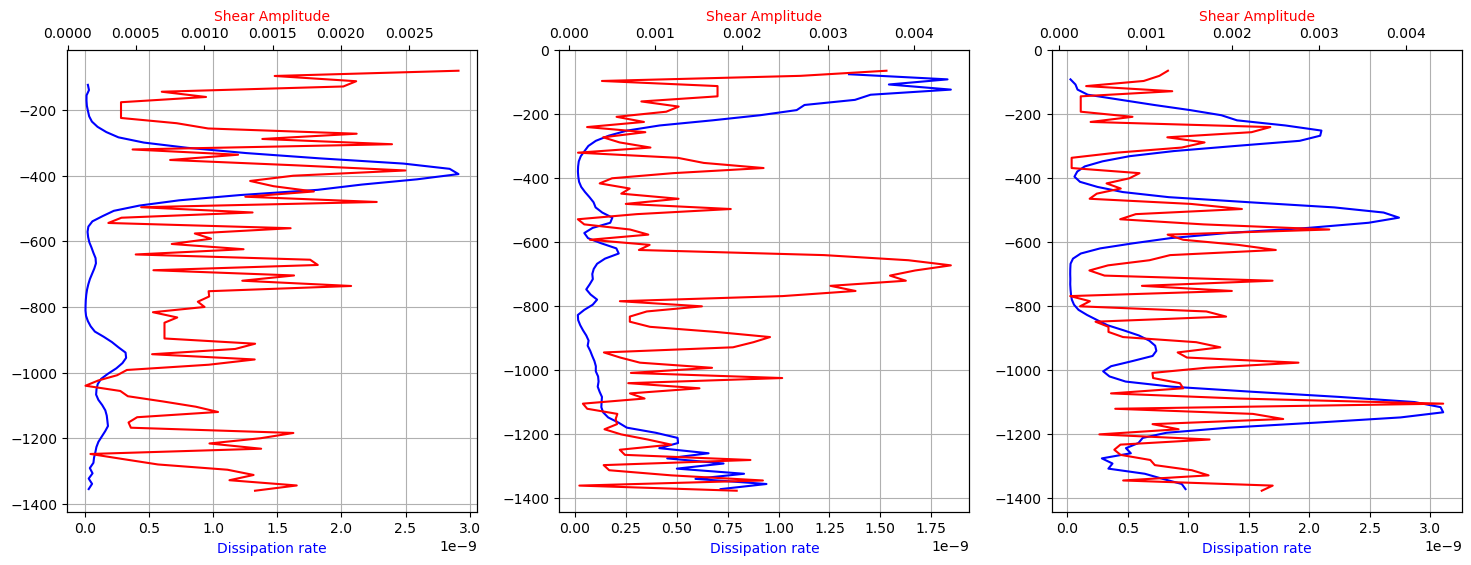

In [84]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
for i,t in enumerate([t0,t1,t2]):
    ax=axs[i]
    ax1 = ax.twiny()
    ax.plot(diag_sh[t]['eps'],-diag_sh[t]['depth_bin'],c='b')
    ax1.plot(0.5*(ds.u**2+ds.v**2).sel(time=t,method='nearest').values,-ds.z.values,c='r')
    ax.set_xlabel('Dissipation rate',c='b');ax1.set_xlabel('KE (raw)',c='r')
    ax.grid()


fig,axs = plt.subplots(1,3,figsize=(18,6))
for i,t in enumerate([t0,t1,t2]):
    ax=axs[i]
    ax1 = ax.twiny()
    ax.plot(diag_sh[t]['eps'],-diag_sh[t]['depth_bin'],c='b')
    ax1.plot(np.abs(ds.UVz.sel(time=t,method='nearest')).values,-ds.z.values,c='r')
    #ax1.plot(ds.bpvz.sel(time=t,method='nearest').values,-ds.z.values,c='r')
    ax.set_xlabel('Dissipation rate',c='b');ax1.set_xlabel('Shear Amplitude',c='r')
    ax.grid()

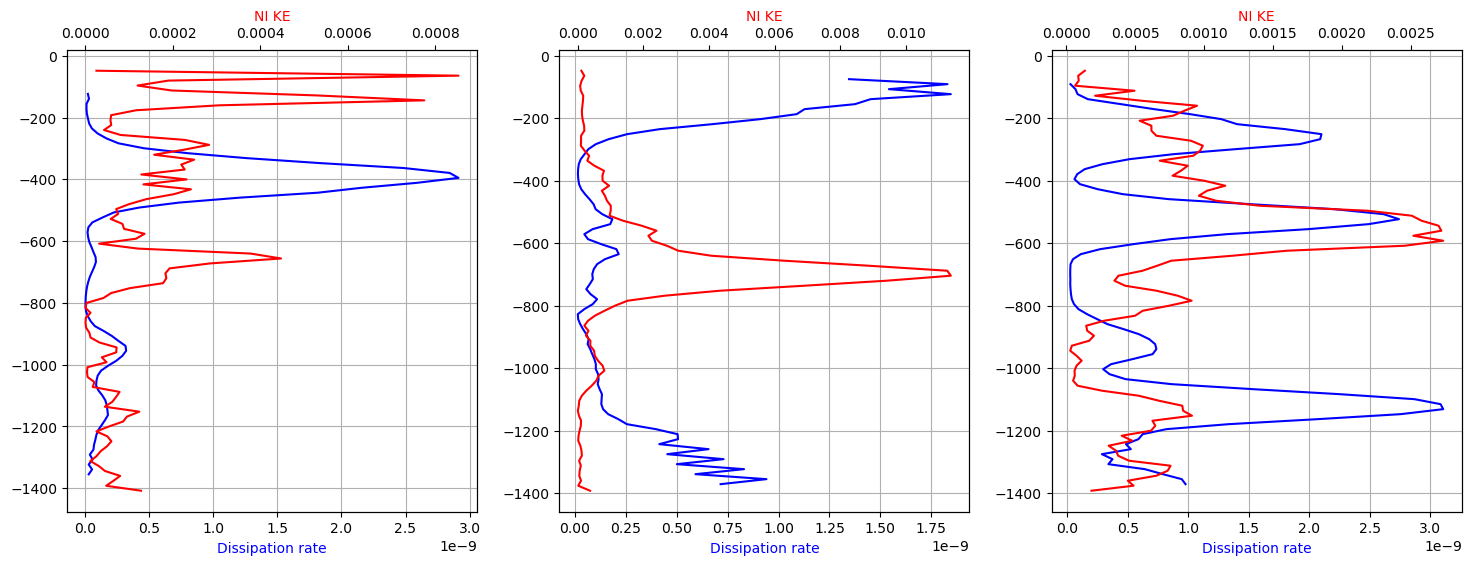

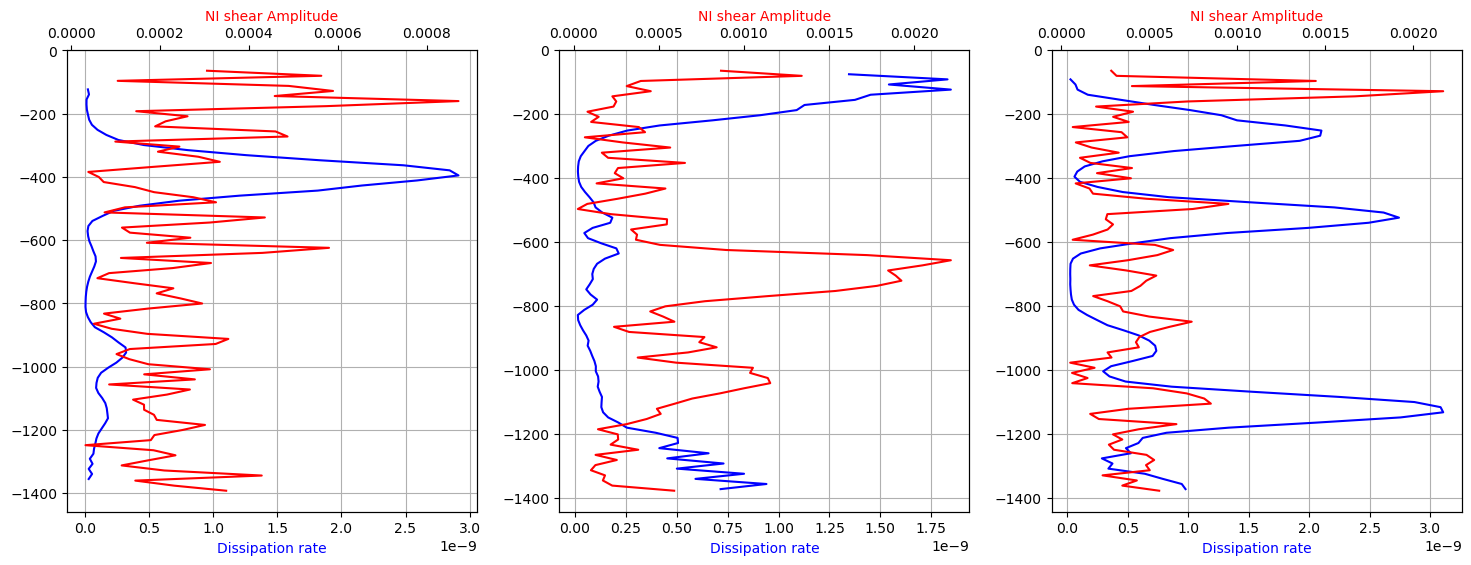

In [62]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
for i,t in enumerate([t0,t1,t2]):
    ax=axs[i]
    ax1 = ax.twiny()
    ax.plot(diag_sh[t]['eps'],-diag_sh[t]['depth_bin'],c='b')
    ax1.plot(ds.ni_ke.sel(time=t,method='nearest').values,-ds.z.values,c='r')
    ax.set_xlabel('Dissipation rate',c='b');ax1.set_xlabel('NI KE',c='r')
    ax.grid()


fig,axs = plt.subplots(1,3,figsize=(18,6))
for i,t in enumerate([t0,t1,t2]):
    ax=axs[i]
    ax1 = ax.twiny()
    ax.plot(diag_sh[t]['eps'],-diag_sh[t]['depth_bin'],c='b')
    ax1.plot(np.abs(ds.bpUVz.sel(time=t,method='nearest')).values,-ds.z.values,c='r')
    #ax1.plot(ds.bpvz.sel(time=t,method='nearest').values,-ds.z.values,c='r')
    ax.set_xlabel('Dissipation rate',c='b');ax1.set_xlabel('NI shear Amplitude',c='r')
    ax.grid()

In [65]:
depth = Temp.depth.values
u_depth = ds.z

In [66]:
def wrap_nan_shearstrain(depth,t,s,lon,lat,**kwargs):
    diag = nan_shearstrain(depth,t,s,lon,lat,**kwargs)[-1]
    return xr.Dataset({k:(['depth_bin'],diag[k]) for k in ['eps','krho','depth_bin']})

In [ ]:
ds_diag = xr.concat([wrap_nan_shearstrain(depth,T_interp.sel(time=t),SP_interp.sel(time=t),lon,lat,
                               ladcp_u = ds.u.sel(time=t),ladcp_v = ds.v.sel(time=t),ladcp_depth=u_depth,
                                method='shear',
                                depth_bin =np.arange(75, np.max(depth), 16),
                                window_size=320,return_diagnostics=True) for t in T_interp.time.values], 'time')

In [68]:
ds_diag = ds_diag.assign_coords(time=T_interp.time.values)
#ds_diag_clim = ds_diag_clim.assign_coords(time=Temp.time.values)
#ds_diag_shst = ds_diag_shst.assign_coords(time=Temp.time.values)
#ds_diag_shst_clim = ds_diag_shst_clim.assign_coords(time=Temp.time.values)

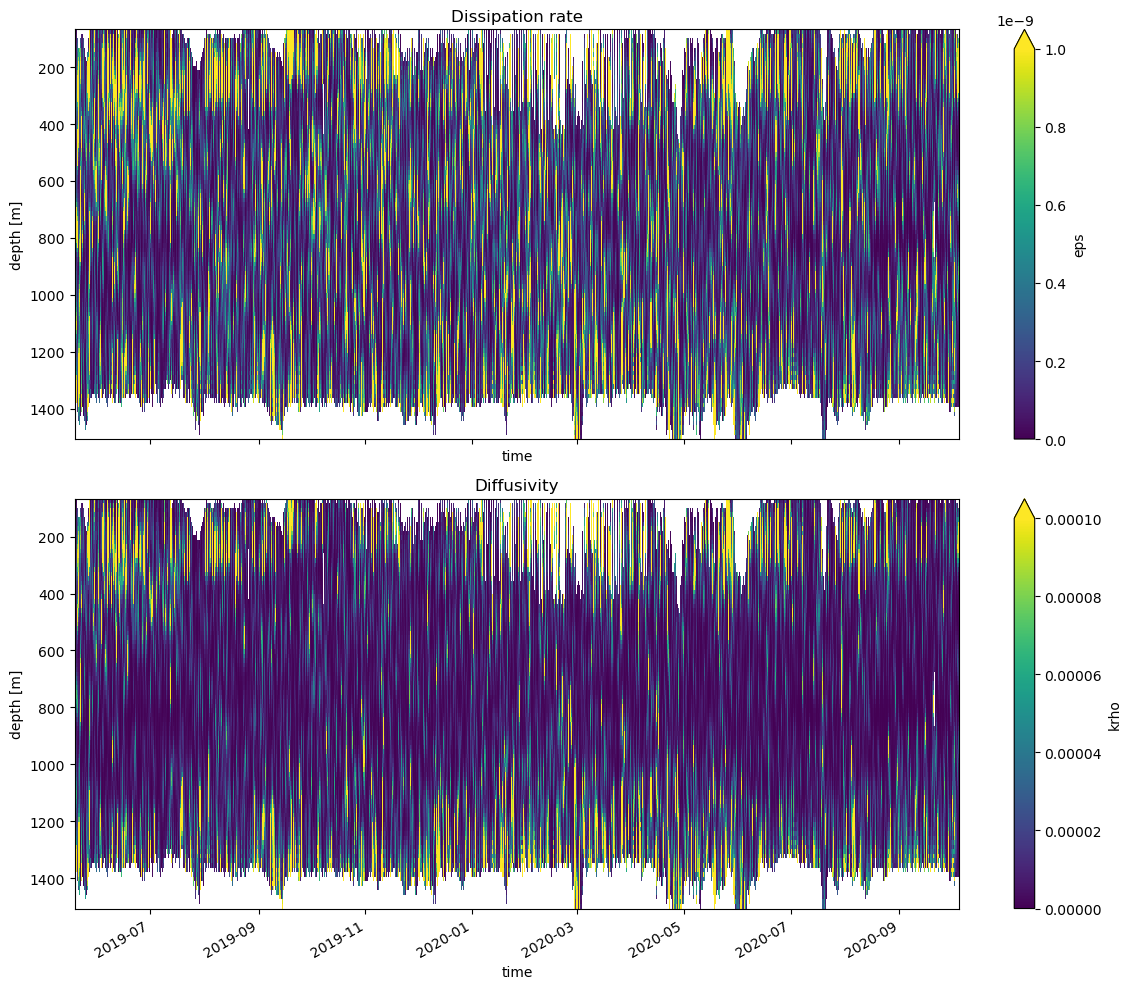

In [86]:
fig,axs = plt.subplots(2,1,figsize=(12,10),sharex=True)
ds_diag.eps.plot(ax=axs[0],y='depth_bin',yincrease=False,vmax=1e-9)
axs[0].set_ylabel('depth [m]')
axs[0].set_title('Dissipation rate')

ds_diag.krho.plot(ax=axs[1],y='depth_bin',yincrease=False,vmax=1e-4)
axs[1].set_ylabel('depth [m]')
axs[1].set_title('Diffusivity')
fig.tight_layout()

Text(0.5, 1.0, '')

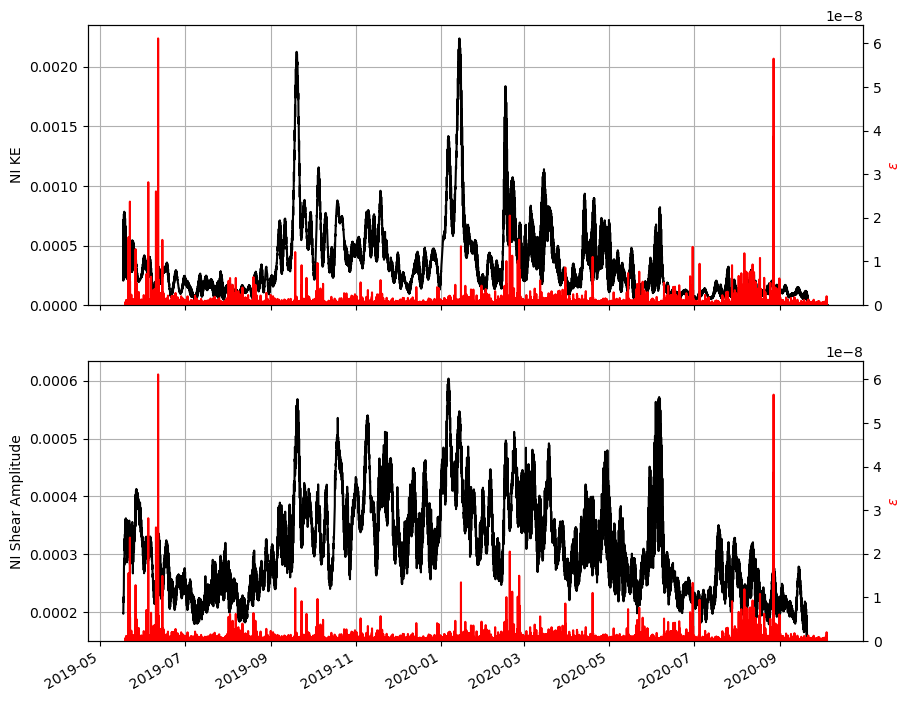

In [133]:

fig,axs = plt.subplots(2,1,figsize=(10,8),sharex=True)
ax=axs[0]
ax1 = ax.twinx()
ds.ni_ke.mean('z').plot(ax=ax,c='k',ylim=(0,None))
ds_diag.eps.mean('depth_bin').plot(ax=ax1,c='r',ylim=(0,None))
ax.grid();ax.set_ylabel('NI KE');ax1.set_ylabel(r'$\epsilon$',c='r')
ax.set_title('')
ax=axs[1]
ax1 = ax.twinx()
np.abs(ds.bpUVz).mean('z').plot(ax=ax,c='k',ylim=(1.5e-4,None))
ds_diag.eps.mean('depth_bin').plot(ax=ax1,c='r',ylim=(0,None))
ax.grid();ax.set_ylabel('NI Shear Amplitude');ax1.set_ylabel(r'$\epsilon$',c='r')
ax.set_title('')

Text(0.5, 0.98, 'Comparison to NIWs properties')

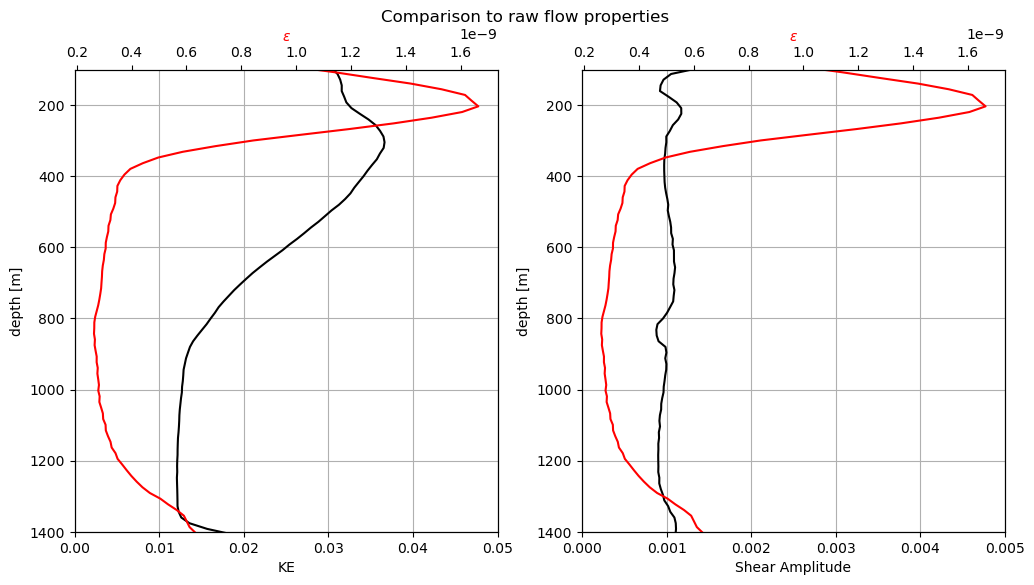

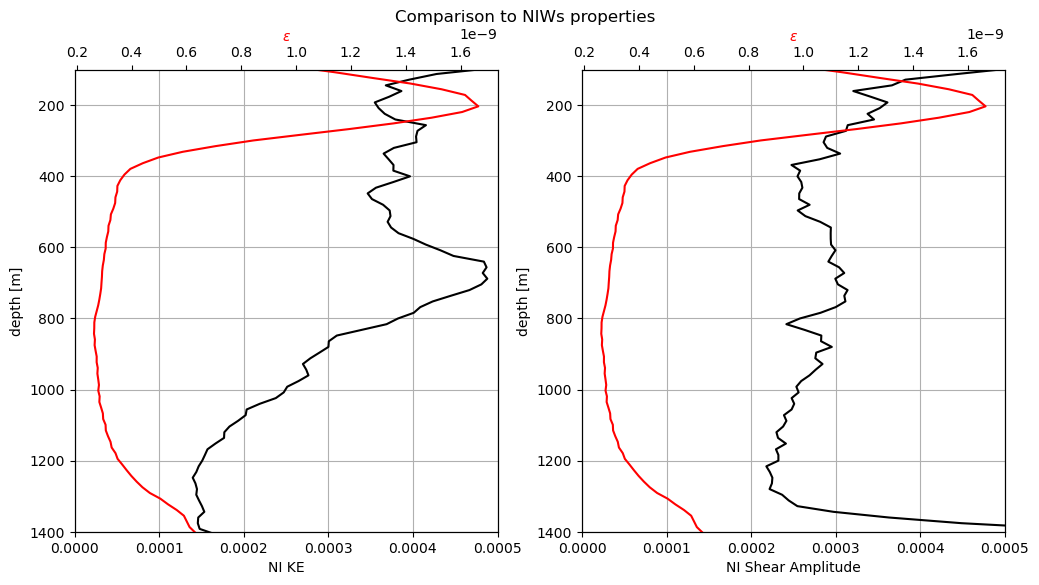

In [127]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
ax=axs[0]
ax1=ax.twiny()
(0.5*(ds.u**2+ds.v**2)).mean('time').plot(ax=ax,c='k',y='z',yincrease=False,xlim=(0,5e-2))
ds_diag.eps.mean('time').plot(ax=ax1,c='r',y='depth_bin')
ax.set_ylim(1400,100);ax.set_title('')
ax.grid();ax.set_xlabel('KE');ax1.set_xlabel(r'$\epsilon$',c='r')

ax=axs[1]
ax1=ax.twiny()
np.abs(ds.UVz).mean('time').plot(ax=ax,c='k',y='z',yincrease=False,xlim=(0,5e-3))
ds_diag.eps.mean('time').plot(ax=ax1,c='r',y='depth_bin')
ax.set_ylim(1400,100);ax.set_title('')
ax.grid();ax.set_xlabel('Shear Amplitude');ax1.set_xlabel(r'$\epsilon$',c='r')
fig.suptitle('Comparison to raw flow properties')

fig,axs = plt.subplots(1,2,figsize=(12,6))
ax=axs[0]
ax1=ax.twiny()
ds.ni_ke.mean('time').plot(ax=ax,c='k',y='z',yincrease=False,xlim=(0,5e-4))
ds_diag.eps.mean('time').plot(ax=ax1,c='r',y='depth_bin')
ax.set_ylim(1400,100);ax.set_title('')
ax.grid();ax.set_xlabel('NI KE');ax1.set_xlabel(r'$\epsilon$',c='r')
ax=axs[1]
ax1=ax.twiny()
np.abs(ds.bpUVz).mean('time').plot(ax=ax,c='k',y='z',yincrease=False,xlim=(0,5e-4))
ds_diag.eps.mean('time').plot(ax=ax1,c='r',y='depth_bin')
ax.set_ylim(1400,100);ax.set_title('')
ax.grid();ax.set_xlabel('NI Shear Amplitude');ax1.set_xlabel(r'$\epsilon$',c='r')
fig.suptitle('Comparison to NIWs properties')